# Modelling Genre

Author-Topic Modelling -> Genre-Topic Modelling

https://nbviewer.jupyter.org/github/rare-technologies/gensim/blob/develop/docs/notebooks/atmodel_tutorial.ipynb

## Latent Dirichlet Allocation

### Training a topic model on the Books corpus

In [2]:
import glob
import random
RND = 12345
random.seed(RND)
from nltk.tokenize import word_tokenize

def chunker(l, n):
    """Yield successive n-sized chunks from l."""
    l = ''.join([c for c in l if c.isalpha() or c.isspace()])
    l = word_tokenize(l)
    l = [t.lower() for t in l]
    for i in range(0, len(l), n):
        yield l[i:i + n]        

class ParagraphIterator(object):
    def __init__(self, path, max_per_book=None,
                 chunk_size=100, max_books=None):
        self.max_books = max_books
        self.max_per_book = max_per_book
        self.chunk_size = chunk_size
        self.doc2genre = {}
        self.genre2doc = {}
        
        self.filenames = list(glob.glob(path))
        random.seed(RND)
        random.shuffle(self.filenames)
        if self.max_books:
            self.filenames = self.filenames[:self.max_books]
        
        self.book2genre = {}
        for filename in self.filenames:
            comps = filename.split('/')
            genre, title = comps[-2:]
            try:
                self.book2genre[title].append(genre)
            except KeyError:
                self.book2genre[title] = [genre]

    def __iter__(self):
        for filename in self.filenames:
            comps = filename.split('/')
            _, title = comps[-2:]
            genres = self.book2genre[title]
            with open(filename, 'r') as f:
                try:
                    if self.max_per_book:
                        text = f.read(self.max_per_book)
                    else:
                        text = f.read()
                except:
                    continue
            for ch in chunker(text, self.chunk_size):
                idx = len(self.doc2genre)
                self.doc2genre[idx] = genres
                for genre in genres:
                    try:
                        self.genre2doc[genre].append(idx)
                    except KeyError:
                        self.genre2doc[genre] = [idx]
                yield ch

Set hyperparams:

In [3]:
path = '/Users/mike/GitRepos/potter/data/other/books_txt_full/*/*.txt'
n_features = 5000
n_topics = 50
n_top_words = 60
max_freq = 0.3
min_wordcount = 20
max_books = 1000
cut_top = 500

Inspect genre overlap:

In [4]:
paragraphs = ParagraphIterator(path, max_books=None)
from collections import Counter
mults = Counter([len(genres) for title, genres in paragraphs.book2genre.items()])
mults

Counter({1: 4257, 2: 2101, 3: 741, 4: 82, 5: 6})

How often do books have multiple genres?

Text(0.5,1,'Distribution of genres over books')

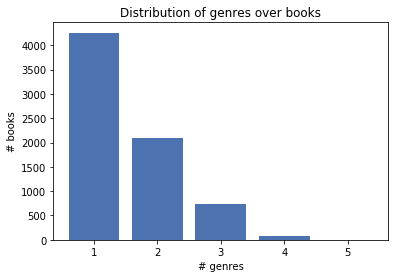

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
x, heights = list(zip(*mults.items()))
plt.bar(x=x, height=heights)
plt.xlabel('# genres')
plt.ylabel('# books')
plt.title('Distribution of genres over books')

How do genre labels cooccur?

['Adventure', 'Fantasy', 'Historical', 'Horror', 'Humor', 'Literature', 'Mystery', 'New_Adult', 'Other', 'Romance', 'Science_fiction', 'Teen', 'Themes', 'Thriller', 'Vampires', 'Young_Adult']


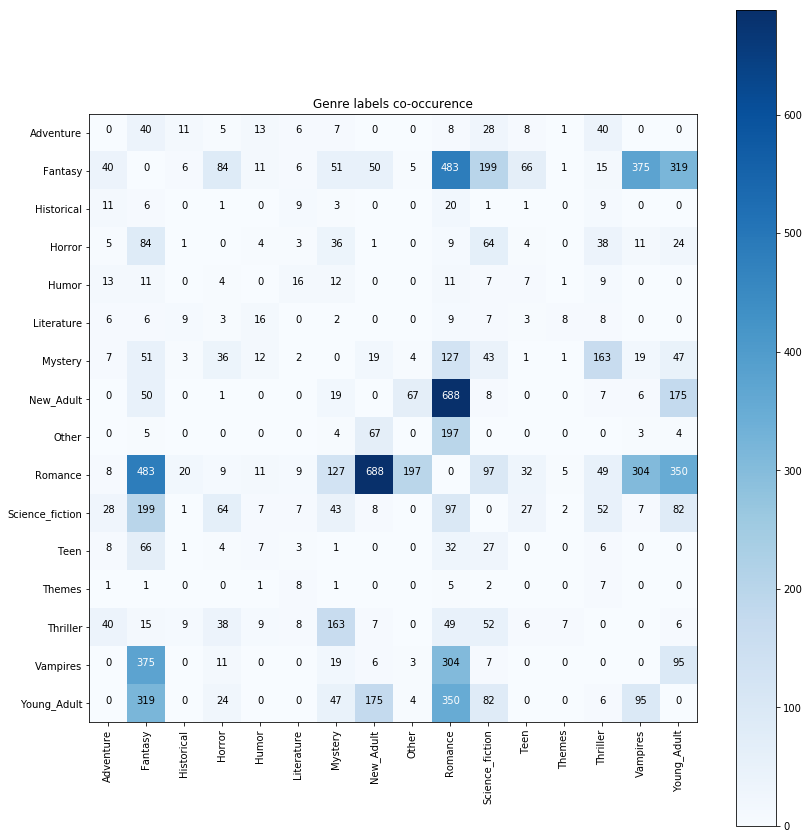

In [6]:
from itertools import combinations
import numpy as np
from itertools import product

G = sorted(set([label for labels in paragraphs.book2genre.values() for label in labels]))
C = np.zeros((len(G), len(G)), dtype=np.int64)
print(G)

for _, genres in paragraphs.book2genre.items():
    for a, b in combinations(genres, 2):
        C[G.index(a), G.index(b)] += 1
        C[G.index(b), G.index(a)] += 1

plt.figure(figsize=(12, 12))
ax = plt.imshow(C, interpolation='nearest', cmap=plt.cm.Blues)
plt.gca().grid(False)
plt.title('Genre labels co-occurence')
plt.colorbar()
tick_marks = np.arange(len(G))
plt.xticks(tick_marks, G, rotation=90)
plt.yticks(tick_marks, G)

thresh = C.max() / 2.
for i, j in product(range(C.shape[0]), range(C.shape[1])):
    plt.text(j, i, format(C[i, j], 'd'),
             horizontalalignment="center",
             color="white" if C[i, j] > thresh else "black")

plt.tight_layout()

How common is each genre?

Text(0.5,1,'Distribution of genres over books')

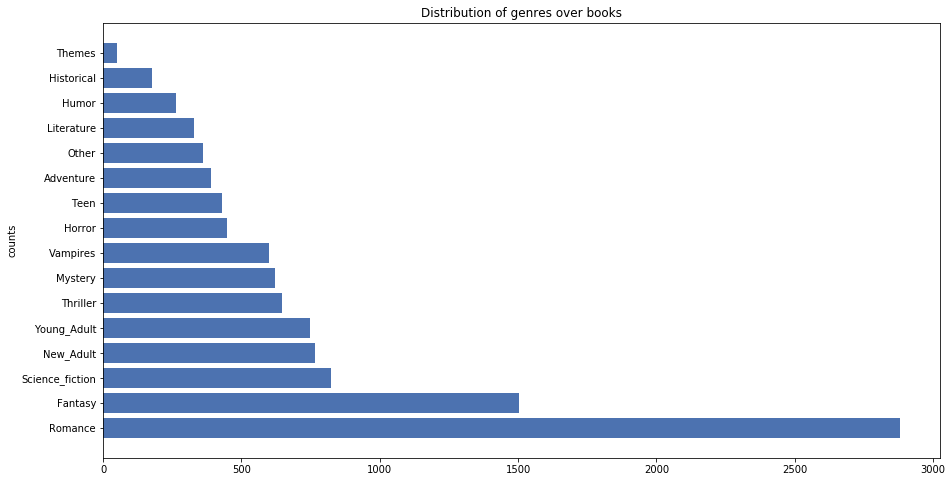

In [7]:
from operator import itemgetter
plt.figure(figsize=(15, 8))
G = Counter([label for labels in paragraphs.book2genre.values() for label in labels])
labels, heights = list(zip(*sorted(list(G.items()), key=itemgetter(1), reverse=True)))
plt.barh(y=range(len(heights)), width=heights)
plt.yticks(range(len(labels)), labels)
plt.ylabel('counts')
plt.title('Distribution of genres over books')

In [8]:
import gensim
from gensim import corpora
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
paragraphs = ParagraphIterator(path, max_books=1000) # devel cut off
dictionary = corpora.Dictionary(paragraphs)
dictionary.filter_extremes(no_below=min_wordcount,
                           no_above=max_freq,
                           keep_n=n_features)
dictionary.filter_n_most_frequent(cut_top)

paragraphs = ParagraphIterator(path, max_books=1000) # devel cut off
doc2genre = paragraphs.doc2genre
genre2doc = paragraphs.genre2doc
bow = [dictionary.doc2bow(doc) for doc in paragraphs]

2018-02-02 23:07:40,241 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-02-02 23:07:45,492 : INFO : adding document #10000 to Dictionary(27833 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:07:51,007 : INFO : adding document #20000 to Dictionary(38347 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:07:56,271 : INFO : adding document #30000 to Dictionary(48412 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:08:01,287 : INFO : adding document #40000 to Dictionary(56012 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:08:07,655 : INFO : adding document #50000 to Dictionary(63877 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:08:12,083 : INFO : adding document #60000 to Dictionary(71989 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:08:17,220 : INFO : adding document 

2018-02-02 23:12:41,598 : INFO : adding document #570000 to Dictionary(248351 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:12:46,615 : INFO : adding document #580000 to Dictionary(251131 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:12:51,843 : INFO : adding document #590000 to Dictionary(253735 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:12:57,102 : INFO : adding document #600000 to Dictionary(256610 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:13:02,232 : INFO : adding document #610000 to Dictionary(258711 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:13:07,988 : INFO : adding document #620000 to Dictionary(261156 unique tokens: ['wes', 'parker', 'monster', 'hunter', 'volume']...)
2018-02-02 23:13:12,648 : INFO : adding document #630000 to Dictionary(263201 unique tokens: ['wes', 'parker', 'monster', 'h

In [ ]:
print(len(doc2genre))
print(len(genre2doc))
print(len(bow))

In [ ]:
lda = gensim.models.ldamodel.LdaModel(corpus=bow,
                                      id2word=dictionary,
                                      num_topics=n_topics,
                                      update_every=0,
                                      chunksize=2000,
                                      passes=3,
                                      random_state=RND)

In [ ]:
print(lda.print_topics(num_topics=10, num_words=20))

In [ ]:
x = lda[bow[0]]
print(x)

### Reading tea leaves: add your own label to the topics

In [ ]:
#!pip install pyldavis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

v = pyLDAvis.gensim.prepare(lda, bow, dictionary)
pyLDAvis.display(v)

- student assigned: provide short interpretative labels for each topic

In [ ]:
### Infer topic on HP + diachronic plot

## A Genre-Topic Model of the Books corpus

In [12]:
from gensim.models import AuthorTopicModel

In [15]:
atmodel = AuthorTopicModel(bow,
                           num_topics=n_topics,
                           doc2author=doc2genre,
                           author2doc=genre2doc,
                           id2word=dictionary,
                           update_every=1,
                           chunksize=5000,
                           passes=3,
                           random_state=RND)
atmodel.save('atmodel')

2018-02-02 23:26:50,240 : INFO : Vocabulary consists of 4500 words.
2018-02-02 23:26:50,241 : INFO : using symmetric alpha at 0.02
2018-02-02 23:26:50,241 : INFO : using symmetric eta at 0.00022222222222222223
2018-02-02 23:26:53,464 : INFO : running online author-topic training, 50 topics, 16 authors, 3 passes over the supplied corpus of 697156 documents, updating model once every 5000 documents, evaluating perplexity every 50000 documents, iterating 50x with a convergence threshold of 0.001000
2018-02-02 23:26:53,466 : INFO : PROGRESS: pass 0, at document #5000/697156
2018-02-02 23:26:57,443 : INFO : merging changes from 5000 documents into a model of 697156 documents
2018-02-02 23:26:57,522 : INFO : topic #25 (0.020): 0.038*"months" + 0.038*"lady" + 0.035*"alexia" + 0.027*"form" + 0.026*"dress" + 0.026*"appearance" + 0.026*"embarrassment" + 0.026*"eight" + 0.025*"massive" + 0.025*"although"
2018-02-02 23:26:57,523 : INFO : topic #10 (0.020): 0.023*"meeting" + 0.018*"garden" + 0.017*

2018-02-02 23:27:40,588 : INFO : topic #2 (0.020): 0.017*"dogs" + 0.014*"village" + 0.011*"warrior" + 0.009*"note" + 0.008*"prince" + 0.007*"stumbled" + 0.007*"fading" + 0.007*"however" + 0.007*"pierced" + 0.007*"raised"
2018-02-02 23:27:40,590 : INFO : topic diff=0.640675, rho=0.408248
2018-02-02 23:27:40,592 : INFO : PROGRESS: pass 0, at document #35000/697156
2018-02-02 23:27:46,709 : INFO : merging changes from 5000 documents into a model of 697156 documents
2018-02-02 23:27:46,761 : INFO : topic #36 (0.020): 0.143*"women" + 0.045*"jesse" + 0.033*"gabrielle" + 0.031*"land" + 0.026*"sea" + 0.023*"vision" + 0.022*"prince" + 0.018*"island" + 0.017*"lay" + 0.015*"east"
2018-02-02 23:27:46,762 : INFO : topic #39 (0.020): 0.515*"edward" + 0.200*"andrew" + 0.081*"ken" + 0.020*"thomas" + 0.017*"sage" + 0.009*"read" + 0.008*"century" + 0.006*"book" + 0.006*"shall" + 0.005*"story"
2018-02-02 23:27:46,763 : INFO : topic #42 (0.020): 0.351*"reid" + 0.187*"victor" + 0.033*"thorne" + 0.030*"abov

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
atmodel = AuthorTopicModel.load('atmodel')

In [ ]:
atmodel.show_topic(21)

In [ ]:
for idx, _ in atmodel.get_author_topics('Vampires', minimum_probability=1e-8):
    print(atmodel.show_topic(idx))
    print('===')

Bad news: https://github.com/RaRe-Technologies/gensim/issues/1166
But PR on the way:
https://github.com/RaRe-Technologies/gensim/pull/1766/commits/f68dfe97b1ccf9d68d155730a5b28a0ba8e37bf5

In [ ]:
new_x = bow[:10]
genre2doc_ = {}
for genre in genre2doc:
    genre2doc_[genre] = list(range(len(new_x)))
doc2genre_ = {i: list(genre2doc.keys())for i in range(10)}

x_, _ = atmodel.inference(new_x,
                          author2doc=genre2doc_,
                          doc2author=doc2genre_,
                          rhot=0.0, # or 1.0
                          collect_sstats=False)

x_ = x_ / x_.sum(axis=1)[:, np.newaxis]
print(x_.shape)
print(x_.sum(axis=1))
print(x_)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
smallest_genre = 0  # Ignore authors with documents less than this.
genres = [atmodel.author2id[a] for a in atmodel.author2id.keys() if len(atmodel.author2doc[a]) >= smallest_genre]
_ = tsne.fit_transform(atmodel.state.gamma[genres, :])  # Result stored in tsne.embedding_

In [ ]:
# Tell Bokeh to display plots inside the notebook.
from bokeh.io import output_notebook
output_notebook()

In [ ]:
#!pip install bokeh

In [ ]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
            author_sizes=author_sizes,
            radii=radii,
        )
    )

# Add author names and sizes to mouse-over info.
hover = HoverTool(
        tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
        ]
    )

p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
show(p)

## word2vec: modelling the muggles and other non-words